In [1]:
# 1 加载必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# 2 定义超参数
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10

In [3]:
# 3 构建Pipeline对图像做处理
pipeline = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))]) #正则化：防止过拟合

In [4]:
# 4 下载、加载数据
from torch.utils.data import DataLoader

# 下载数据
train_set = datasets.MNIST("data", train=True, download=True, transform=pipeline)

test_set = datasets.MNIST("data", train=False, download=True, transform=pipeline)

# 加载数据
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
examples = enumerate(test_loader) #  在同时需要用到index和value值的时候可以用到enumerate，参数为可遍历的变量，如字符串，列表等，返回enumerate类。
batch_index,(example_data, example_targets) = next(examples)
print(example_targets) # 对应图片标签
print(example_data.shape) # 形状

tensor([0, 1, 8, 1, 6, 3, 3, 0, 5, 3, 3, 6, 5, 9, 1, 4])
torch.Size([16, 1, 28, 28])


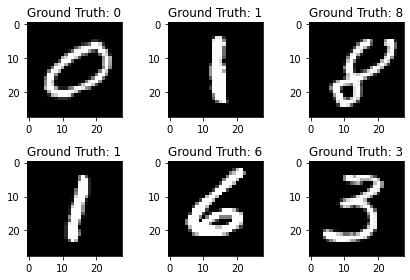

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  # plt.xticks([])
  # plt.yticks([])
plt.show()

In [7]:
# 5 构建网络模型
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) # 灰度输入通道1 输出通道10 Kernel_size 5 步长stride默认为1
        self.conv2 = nn.Conv2d(10, 20, 3) # 输入通道10 输出通道20 Kernel_size 3 步长stride默认为1
        self.fc1 = nn.Linear(20*10*10, 500)
        self.fc2 = nn.Linear(500, 10) # 输入通道 500 输出通道 10
    
    def forward(self, x):
        input_size = x.size(0) # tensor: batch_size * 1 * 28 * 28 此处取Batch_size
        x = self.conv1(x) # 输入:batch_size*1*28*28 输出:batch_size*10*24*24 (28-5+1=24)
        x = F.relu(x) # shape不变
        x = F.max_pool2d(x, 2, 2) # kernel_size 为 2 步长为2 输出:batch*10*12*12
        
        x = self.conv2(x) # 输入:batch*10*12*12 输出:batch*20*10*10
        x = F.relu(x)
        
        x = x.view(input_size, -1) # Flatten 20*10*10
        
        x = self.fc1(x) # 输入:batch*2000 输出:batch*500
        x = F.relu(x)
        
        x = self.fc2(x) # 输入:batch*500 输出:batch*10
        
        output = F.log_softmax(x, dim=1)
        
        return output

In [8]:
# 6 定义优化器与模型
model = Net().to(DEVICE)

optimizer = optim.Adam(model.parameters()) 

In [9]:
# 7 定义训练方法
def train_model(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # 部署到DEVICE
        data, target = data.to(device), target.to(device)
        # 梯度初始化为0
        optimizer.zero_grad()
        # 训练结果
        output = model(data)
        # 计算损失
        loss = F.cross_entropy(output, target) # 交叉熵 二分类用Sigmod
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        if batch_index % 3000 ==0:
            print("Train Epoch:{} \t Loss:{:.6f}".format(epoch, loss.item()))
        

In [10]:
# 8 定义测试方法
def test_model(model, device, test_loader):
    # 模型验证
    model.eval()
    # 正确率
    correct = 0.0
    # 测试损失
    test_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            #部署到device
            data, target = data.to(device), target.to(device)
            # 测试数据
            output = model(data)
            # 计算测试损失
            test_loss += F.cross_entropy(output, target).item()
            # 找到概率值最大的下标
            pred = output.max(1, keepdim=True)[1] # 值,索引
            # 累计正确率
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss = test_loss / len(test_loader.dataset)
        print("Test -- Average loss:{:.4f}, Accuracy : {:.3f}".format(test_loss, 100.0 * correct/ len(test_loader.dataset)))

In [11]:
# 9 调用方法 7、8
for epoch in range(1, EPOCHS + 1):
    train_model(model, DEVICE, train_loader, optimizer, epoch)
    test_model(model, DEVICE, test_loader)

Train Epoch:1 	 Loss:2.286679
Train Epoch:1 	 Loss:0.009805
Test -- Average loss:0.0033, Accuracy : 98.210
Train Epoch:2 	 Loss:0.000305
Train Epoch:2 	 Loss:0.023841
Test -- Average loss:0.0035, Accuracy : 98.300
Train Epoch:3 	 Loss:0.042324
Train Epoch:3 	 Loss:0.000793
Test -- Average loss:0.0027, Accuracy : 98.660
Train Epoch:4 	 Loss:0.000159
Train Epoch:4 	 Loss:0.003148
Test -- Average loss:0.0029, Accuracy : 98.840
Train Epoch:5 	 Loss:0.000006
Train Epoch:5 	 Loss:0.000086
Test -- Average loss:0.0050, Accuracy : 98.240
Train Epoch:6 	 Loss:0.001115
Train Epoch:6 	 Loss:0.000328
Test -- Average loss:0.0041, Accuracy : 98.510
Train Epoch:7 	 Loss:0.005272


KeyboardInterrupt: 